# Houses Prices Prediction | Heterogeneous ensemble methods


## Ensemble learning

Ensemble learning in machine learning is the practice of **combining multiple models** to try and achieve higher overall model performance. 

Ensembles can consist of multiple models trained on the same dataset. Each of these models is used to make predictions on the same input, then these predictions are aggregated across all models in some way (for example, by taking the mean) to produce the final output.   

Other than the possibility of improving model performance, there are [lots of other reasons](https://towardsdatascience.com/simple-guide-for-ensemble-learning-methods-d87cc68705a2) why we might want to build an ensemble. 

In this train, we explore some **heterogeneous ensemble** methods.

## Heterogeneous ensembles

This type of ensemble consists of **different types of models**, *so we can add pretty much any regression model we want*.  

Here we investigate two ways of combining models which are different in nature: **voting** and **stacking**.  

## 1. Training the individual models

Let's start by training different individual machine learning models on the same data. 

We'll train a `linear regression`, a `decision tree`, and an `SVR` (i.e. [support vector machine regression](https://www.saedsayad.com/support_vector_machine_reg.htm) )

#### Import libraries and data

First let's import libraries and load some data. 

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

We will use a version of [Kaggle's](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) house price regression data for predicting the price of a house given a set of variables.

In [2]:
df = pd.read_csv("https://github.com/Explore-AI/Public-Data/blob/master/house_price_by_area.csv?raw=true")
df.head()

,LotArea,SalePrice
0,138,1204000
1,145,1274000
2,152,1673000
3,152,1232000
4,152,1195600


The data consists of two variables:
 * `LotArea` in m$^{2}$.
 * `SalePrice` in Rands.
 
We will be using the value of `LotArea` (independent variable) to try and predict the `SalePrice` (dependent variable).   

Let's take a look at the data using `matplotlib`:

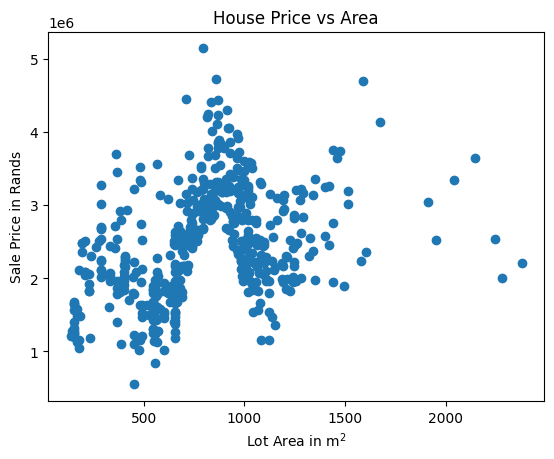

In [3]:
X = df["LotArea"] # Independent variable
y = df["SalePrice"] # Dependent variable

plt.scatter(X,y) # Create scatter plot
plt.title("House Price vs Area")
plt.xlabel("Lot Area in m$^2$")
plt.ylabel("Sale Price in Rands")
plt.show()

#### Pre-processing

Next we scale and split our dataset into training and testing sets so that we can later evaluate the performance of the model.

In [4]:
# Initialise the scalers
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Normalise X and y
X_scaled = x_scaler.fit_transform(np.array(X)[:,np.newaxis]) 
y_scaled = y_scaler.fit_transform(np.array(y)[:,np.newaxis]) 

# Set test size to 20 % of training data
x_train, x_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=0.2,random_state=6)

### a) Linear regression

Create and fit the model:

In [5]:
# Instantiate linear regression model
lin_reg = LinearRegression()

lin_reg.fit(x_train,y_train)

LinearRegression()

Check performance using the root mean square error (RMSE) metric: 

RMSE:  0.9597285404528205


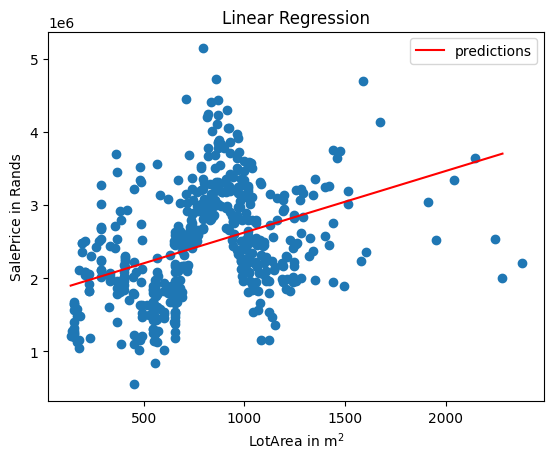

In [6]:
y_pred = lin_reg.predict(x_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred)))

# Plot the linear regression prediction line over data
x_domain = np.linspace(min(x_train),max(x_train),100)

y_pred_rescaled = y_scaler.inverse_transform(lin_reg.predict(x_domain))
x_rescaled = x_scaler.inverse_transform(x_domain) 

plt.figure()
plt.scatter(X, y)
plt.plot(x_rescaled, y_pred_rescaled, color="red", label='predictions')
plt.xlabel("LotArea in m$^2$")
plt.ylabel("SalePrice in Rands")
plt.title("Linear Regression")
plt.legend()
plt.show()

### b) Decision tree

Create and fit the model:

In [7]:
# Instantiate regression tree model
regr_tree = DecisionTreeRegressor(max_depth=3)

regr_tree.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=3)

Check performance using the root mean square error (RMSE) metric:

RMSE:  0.8155834161717601


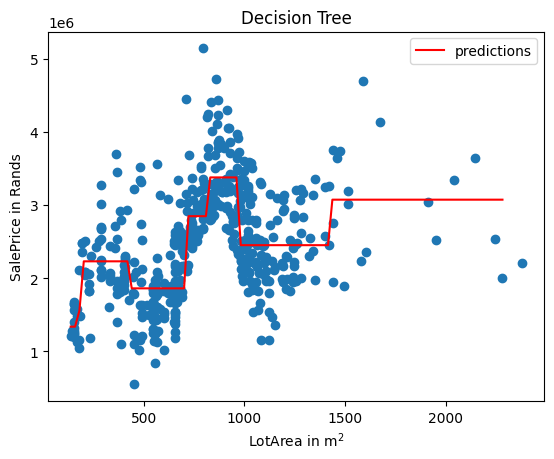

In [8]:
y_pred = regr_tree.predict(x_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred)))

# Plot the regression tree prediction line over data
x_domain = np.linspace(min(x_train),max(x_train),100)

y_pred_rescaled = y_scaler.inverse_transform(regr_tree.predict(x_domain).reshape(-1, 1))
x_rescaled = x_scaler.inverse_transform(x_domain) 

plt.figure()
plt.scatter(X, y)
plt.plot(x_rescaled, y_pred_rescaled, color="red", label='predictions')
plt.xlabel("LotArea in m$^2$")
plt.ylabel("SalePrice in Rands")
plt.title("Decision Tree")
plt.legend()
plt.show()

### c) Support vector regression

Create and fit the model:

In [9]:
# Instantiate support vector regression model
sv_reg = SVR(kernel='rbf', gamma='auto')

sv_reg.fit(x_train,y_train[:,0])

SVR(gamma='auto')

Check performance using the root mean square error (RMSE) metric:

RMSE:  0.7823020808791088


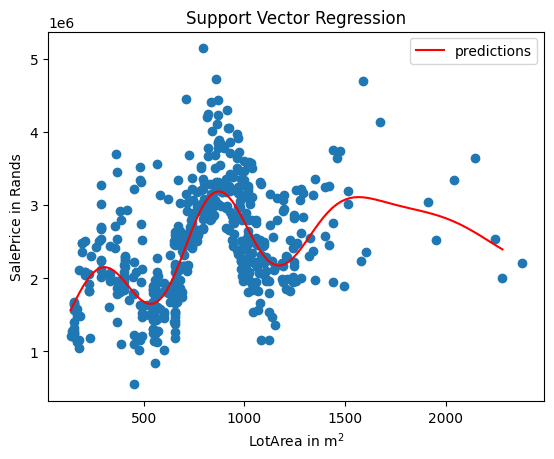

In [10]:
y_pred = sv_reg.predict(x_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred)))

# Plot the SVR prediction line over data
x_domain = np.linspace(min(x_train),max(x_train),100)

y_pred_rescaled = y_scaler.inverse_transform(sv_reg.predict(x_domain).reshape(-1, 1))
x_rescaled = x_scaler.inverse_transform(x_domain) 

plt.figure()
plt.scatter(X, y)
plt.plot(x_rescaled, y_pred_rescaled, color="red", label='predictions')
plt.xlabel("LotArea in m$^2$")
plt.ylabel("SalePrice in Rands")
plt.title("Support Vector Regression")
plt.legend()
plt.show()

## 2. Heterogeneous ensembling in Python

### a) Voting

Voting involves combining individual model outputs through a kind of "[majority rule](https://en.wikipedia.org/wiki/Majority_rule)" paradigm. 

This process of prediction aggregation varies in the context of regression and classification tasks:
- **Regression** – we take the **average** or **weighted average** of all predictions.
- **Classification** – we use the **mode** of all predictions (i.e. most frequently occurring prediction).

Within the code below, we instantiate, train, and evaluate such a voting ensemble using `sklearn`'s `VotingRegressor` class. 

In [11]:
# Importing the VotingRegressor class from sklearn
from sklearn.ensemble import VotingRegressor

**Building the voting ensemble:**

In [12]:
# Define the models which we'll include in our ensemble. 
# We pass a list of tuples, which each have a string identifier for the
# model (arbitrary choice), along with the actual instantiated sklearn model.  
models = [("LR",lin_reg),("DT",regr_tree),("SVR",sv_reg)]

# Specify weights for weighted model averaging
model_weightings = np.array([0.1,0.3,0.6])
v_reg = VotingRegressor(estimators=models,weights=model_weightings)

At this point, we have **built a voting-based ensemble** that combines:
- 10% of linear regression model output
- 30% of decision tree output
- 60% of support vector regression output

to make a final prediction. 

**Training the voting ensemble:**

Note (from the following) that sklearn saves all the input model hyper-parameters.

In [13]:
v_reg.fit(x_train,y_train[:,0])

VotingRegressor(estimators=[('LR', LinearRegression()),
                            ('DT', DecisionTreeRegressor(max_depth=3)),
                            ('SVR', SVR(gamma='auto'))],
                weights=array([0.1, 0.3, 0.6]))

**Checking the performance of the voting ensemble:**

RMSE:  0.7804899566713737


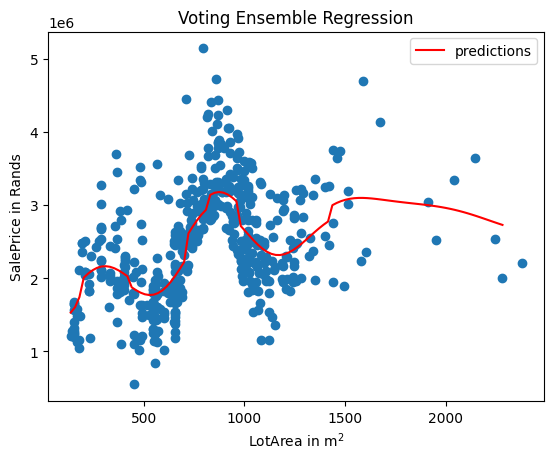

In [14]:
y_pred = v_reg.predict(x_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred)))

# plot the voting regression prediction line over data
x_domain = np.linspace(min(x_train),max(x_train),100)

y_pred_rescaled = y_scaler.inverse_transform(v_reg.predict(x_domain).reshape(-1, 1))
x_rescaled = x_scaler.inverse_transform(x_domain) 

plt.figure()
plt.scatter(X, y)
plt.plot(x_rescaled, y_pred_rescaled, color="red", label='predictions')
plt.xlabel("LotArea in m$^2$")
plt.ylabel("SalePrice in Rands")
plt.title("Voting Ensemble Regression")
plt.legend()
plt.show()

There you have it. We managed to combine our initial three models in a way that improves overall performance.

> Within the above code we've provided weighted parameters for our voting ensemble which improve the overall performance of the regression task. There **may be better weightings** of these predictions that improve the performance even further. Can you try and run the above code cells now with **your own chosen weights** to see if you can beat the current score?

### b) Stacking

While we hope that you enjoyed playing around with the voting weights in the previous section, you may have found the overall exercise frustrating due to the difficulty of knowing how your choice of weightings would affect the ensemble's performance. As such, a natural question may have crossed your intelligent mind:

>What is a principled way of choosing the optimal voting weights for this ensemble?

If we take a step back, we can see that this question can actually be framed as another machine learning problem! After all, this entire time we have been looking at models that can accurately weight various variables in order to map them to an appropriate output. 

So what stops us from weighting the outputs of multiple base models with that of another model?

The hierarchical approach we are alluding to above, where the outputs of multiple trained base models (sometimes called **base learners**) are fed into another model (referred to as a **meta-model** or meta-learner), is formally known as **stacking**.

<img src="https://github.com/Explore-AI/Pictures/blob/master/Model_stacking.png?raw=true" width=65%/>

We illustrate this process within the figure above, where we can see the **predictions of base learners feeding into a meta-learner**. The training process is as follows (all handled by the stacking module):

   1. Each individual base learner is trained in turn on the same training dataset.
    
   2. A validation set is used to generate predictions on unseen observations from each of the trained base learners.
    
   3. These predictions – the outputs from the base learners – are used as the inputs for the meta-learner model. The meta-learner trains on these observations, using the labels from the validation set as the response variable.

<a title="Supun Setunga / CC BY-SA (https://creativecommons.org/licenses/by-sa/4.0)"><img width="640" alt="Stacking" src="https://upload.wikimedia.org/wikipedia/commons/d/de/Stacking.png"></a>

Training the meta-learner effectively teaches it how to 'blend' the outputs of each of the base learners together to produce a single prediction.

Let's see how this works in `sklearn`. To do so, we'll make use of the `StackingRegressor` class. 

In [15]:
# NB: The StackingRegressor is available in version 0.22 of sklearn onwards. 
# Please use pip or conda to update your version if this line throws an error. 
from sklearn.ensemble import StackingRegressor

**Building the stacking ensemble:**

In [16]:
# For clarity, we declare our model list again here 
models = [("LR",lin_reg),("DT",regr_tree),("SVR",sv_reg)]

# Instead of choosing model weightings, we now declare the meta-learner model for our stacking ensemble.  
meta_learner_reg = LinearRegression()

s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)

We now have our stacking ensemble declared. It contains our familiar base learners of linear regression, regression tree, and support vector regression. 

We've also declared our meta-learner as another linear regression model.  

> Before we go on to fit and evaluate our model, it's important to understand what we're trading off by using stacking instead of simple voting to possibly improve our ensemble performance. Within the latter technique, once our base models are trained we can immediately get predictions to derive a final weighted prediction. Using stacking, however, we need two training passes: one for the base learners, and then another for the meta-learner. This essentially means that we **gain metric performance** at the expense of **extra computational requirements**.    

**Training the stacking ensemble:**

In [17]:
s_reg.fit(x_train,y_train[:,0])

StackingRegressor(estimators=[('LR', LinearRegression()),
                              ('DT', DecisionTreeRegressor(max_depth=3)),
                              ('SVR', SVR(gamma='auto'))],
                  final_estimator=LinearRegression())

**Checking the performance of the voting ensemble:**

RMSE:  0.7778568350749011


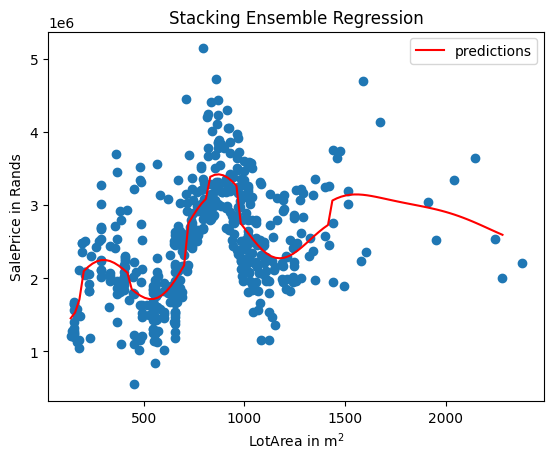

In [18]:
y_pred = s_reg.predict(x_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred)))

# plot the stacking regression prediction line over data
x_domain = np.linspace(min(x_train),max(x_train),100)

y_pred_rescaled = y_scaler.inverse_transform(s_reg.predict(x_domain).reshape(-1, 1))
x_rescaled = x_scaler.inverse_transform(x_domain) 

plt.figure()
plt.scatter(X, y)
plt.plot(x_rescaled, y_pred_rescaled, color="red", label='predictions')
plt.xlabel("LotArea in m$^2$")
plt.ylabel("SalePrice in Rands")
plt.title("Stacking Ensemble Regression")
plt.legend()
plt.show()

And there you have it – our stacking ensemble achieves a better RMSE than the voting ensemble; however, it requires an extra training step to do so.